In [ ]:
# Works best with jupyter-notebook

In [1]:
%matplotlib notebook 
#%matplotlib widget 
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
import math
import numpy as np

from roboticstoolbox import *
import roboticstoolbox as rtb
import roboticstoolbox.tools.trajectory as tr

from spatialmath import *
from spatialmath.base import *
import spatialmath.base.symbolic as sym

import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# Lecture 5.8 DH Parameterization

Denavit-Hartenberg parameterisation only uses 4 numbers to desribe each joint. 

Let's study DH parameters usin a 2-link planar robot model. We have 2 links (though the base is referred as link 0) and 2 joints. 

In [2]:
p2 = rtb.models.DH.Planar2()
print(p2)

┏━━━━┳━━━━━┳━━━━┳━━━━━━┓
┃θⱼ  ┃ dⱼ  ┃ aⱼ ┃  ⍺ⱼ  ┃
┣━━━━╋━━━━━╋━━━━╋━━━━━━┫
┃ q1 ┃ 0.0 ┃  1 ┃ 0.0° ┃
┃ q2 ┃ 0.0 ┃  1 ┃ 0.0° ┃
┗━━━━┻━━━━━┻━━━━┻━━━━━━┛

┌─────┬──────┬──────┐
│name │ q0   │ q1   │
├─────┼──────┼──────┤
│  qz │  0°  │  0°  │
│  q1 │  0°  │  90° │
│  q2 │  90° │ -90° │
└─────┴──────┴──────┘



<IPython.core.display.Javascript object>


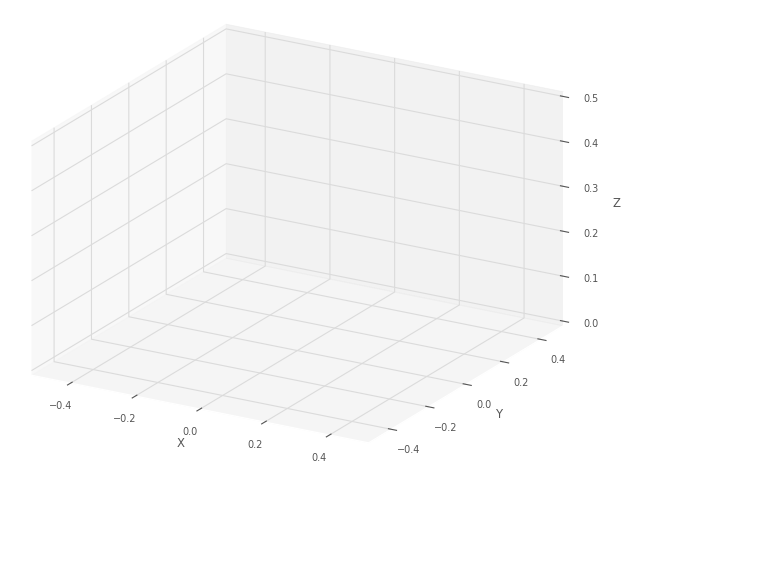

RuntimeError: cannot use teach panel under Jupyter

In [3]:
import matplotlib; #matplotlib.use("nbAgg") 
from mpl_toolkits.mplot3d import Axes3D

p2.q=[0.2, 0.3]
p2.teach();

Given a set of joint anles, we can then capture the pose of the end-effector of the robot

In [4]:
print(p2.fkine(p2.q))

   0.877583   -0.479426    0           1.85765      
   0.479426    0.877583    0           0.678095     
   0           0           1           0            
   0           0           0           1            



If we want to retrieve scaffolded Homogenous transforms (i.e. 0_T_1, 0_T_2, ... 0_T_N) you can use fkine_all()

In [5]:
T = p2.fkine_all(p2.q)
print(T)
type(T)
print('0_T_1 transformation: ', T[0])
print('0_T_2 transformation: ', T[1])

[0] =
   0.980067   -0.198669    0           0.980067     
   0.198669    0.980067    0           0.198669     
   0           0           1           0            
   0           0           0           1            
[1] =
   0.877583   -0.479426    0           1.85765      
   0.479426    0.877583    0           0.678095     
   0           0           1           0            
   0           0           0           1            

0_T_1 transformation:     0.980067   -0.198669    0           0.980067     
   0.198669    0.980067    0           0.198669     
   0           0           1           0            
   0           0           0           1            

0_T_2 transformation:     0.877583   -0.479426    0           1.85765      
   0.479426    0.877583    0           0.678095     
   0           0           1           0            
   0           0           0           1            



### Puma 560 Model
Now, let's look at the 6 DOF puma 560 model.

In [6]:
puma = rtb.models.DH.Puma560()
print(puma)

ModuleNotFoundError: No module named 'rtbdata'

Defined joint configurations are:
- qz, zero joint angle configuration, ‘L’ shaped configuration
- qn, arm is at a nominal non-singular configuration
- qr, vertical ‘READY’ configuration
- qs, arm is stretched out in the x-direction

In [ ]:
print(puma.qz)
puma.plot(puma.qz);

In [ ]:
# Arm in non-singular config
print(puma.qn)
puma.plot(puma.qn);

In [ ]:
# Upwards in the ready position
print(puma.qr)
puma.plot(puma.qr);

In [ ]:
# Stretched in the x-direction
print(puma.qs)
puma.plot(puma.qs);

You can also arbitrarily assign the values of the joint angles to produce a particular end-effector pose in Homogenous transformation form.

In [ ]:
T = puma.fkine([0.1, 0.2, 0.3, 0.4, 0.3, 0.2])
print(T)

# Student Exercise... 
Explore how different joint angle configurations affects the end-effector position and orientation of the robot's end-effector.

## Base and Tool Transform

In [ ]:
# See the base transform
puma.base

In [ ]:
# See the tool transform  
puma.tool

We can modify the base via translations or rotations

In [ ]:
puma.base = SE3.Tx(10)*SE3.Ty(15)*SE3.Tz(2)
puma.base
T = puma.fkine([0.1, 0.2, 0.3, 0, 0, 0])
print(T)

In [ ]:
# Rotate it upside down
puma.base = SE3.Rx(np.pi)
T = puma.fkine([0.1, 0.2, 0.3, 0, 0, 0])
print(T)

# Student exercise:
Try changing the tool with an offset of 0.05m in the z-direction. And see how the coords change

### Visualize Trajectory Generation with your Robot

We can now imagine moving from a starting configuration to a final configuration with our robot. If we would like to display this smooth trajectory, we can use jtraj. Let's move from the puma's qz to qn

In [ ]:
traj = tr.jtraj(puma.qz,puma.qn,50)

The robot class then offers an easy way to plot a sequence of angles as those generated by jtraj. We can simply use the plot() method in the class.

In [ ]:
puma.plot(traj.y);

We can also plot the joint angles directly using the convenience method qplot

In [ ]:
rtb.qplot(traj.y)

### ETS Definition of a PUMA robot

Beyond the DH parameter, we can use the ETS format we saw earlier to also define the kinematics of the robot as a sequence of simple rigid-body transformations – pure translation or pure rotation – each with either a constant parameter or a free parameter which is a joint variable.

In [ ]:
from roboticstoolbox import ETS as E

# Links
l1 = 0.672; l2 = 0.2337; l3 = 0.4318; l4 = -0.0837; l5 = 0.4318; l6 = 0.0203

# ETS
e = E.tz(l1) * E.rz() * E.ty(l2) * E.ry() * E.tz(l3) * E.tx(l6) * E.ty(l4) * E.ry() * E.tz(l5) * E.rz() * E.ry() * E.rz()
print(e)

We can now use the ERobot supercalls which represents the kinematics of a serial-link manipulator.


ERobot partitions the elementary transform sequence into a series of links and joints – link frames are declared after each joint variable as well as the start and end of the sequence. The ERobot can represent single-branched robots with any combination of revolute and prismatic joints, but can also represent more general branched mechanisms.

In [ ]:
puma = rtb.ERobot(e)
print(puma)

### Symbolic Reprensetation of a 6 DOF Robot
You can define the generalized joint coordinates of a robot as symbolic variables and then pass them directly into the fkine function.

In [ ]:
q = base.sym.symbol("q_:6") # q = (q_1, q_2, ... q_5)
print(q)

You can then visualize a specific element, say the symoblic value for x. Use sym.simplify() for better visualization

In [ ]:
T=puma.fkine_all(q)

In [ ]:
sym.simplify(T.t[0])